In [2]:
import pandas as pd
import numpy as np
import configparser
import requests
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import datetime, timedelta
import time
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from arch import arch_model

In [3]:
# Load credentials from config file
config = configparser.ConfigParser()
config.read('pyalgo.cfg')

consumer_id = config['ssi']['ConsumerID']
consumer_secret = config['ssi']['ConsumerSecret']
private_key = config['ssi']['PrivateKey']

In [4]:
# Step 1: Request access token
def get_access_token(consumer_id, consumer_secret, private_key):
    url = "https://fc-data.ssi.com.vn/api/v2/Market/AccessToken"
    headers = {"Content-Type": "application/json"}
    data = {
        "consumerID": consumer_id,
        "consumerSecret": consumer_secret,
        "privateKey": private_key
    }
    res = requests.post(url, json=data, headers=headers)
    res.raise_for_status()
    response = res.json()

    # Extract access token from response
    if "data" in response and "accessToken" in response["data"]:
        return response["data"]["accessToken"]
    else:
        raise ValueError("Access token not found in response:", response)

# Step 2: Get stock price using access token
def get_stock_price(symbol, token, start_date, end_date):
    url = "https://fc-data.ssi.com.vn/api/v2/Market/DailyStockPrice"
    headers = {
        "Authorization": f"Bearer {token}",
        "Accept": "application/json"
    }
    params = {
        "Symbol": symbol,
        "FromDate": start_date,
        "ToDate": end_date,
        "Market": "HOSE",
        "PageIndex": "1",
        "PageSize": "50"
    }
    res = requests.get(url, headers=headers, params=params)
    res.raise_for_status()
    return res.json()

In [5]:
# Define token
token = get_access_token(consumer_id, consumer_secret, private_key)

In [6]:
stock = pd.DataFrame(columns=['TradingDate', 'ClosePrice'])

# Historical data

In [7]:
symb = 'VCB'
date = datetime.today()

for i in range(20):
    end_date = date.strftime("%d/%m/%Y")
    start_date = (date - timedelta(days=30)).strftime("%d/%m/%Y")
    data = get_stock_price(symb, token, start_date, end_date)
    df = pd.DataFrame(data['data'])

    # Ensure correct types
    df['TradingDate'] = pd.to_datetime(df['TradingDate'], dayfirst=True)
    df['ClosePrice'] = pd.to_numeric(df['ClosePrice'], errors='coerce')
    
    df1 = df.loc[df['Symbol'] == symb, ['TradingDate', 'ClosePrice']]

    # Append to master DataFrame
    stock = pd.concat([stock, df1], ignore_index=True)

    # Adjust date back
    date -= timedelta(days=31)

    # Wait before the next request to respect rate limit
    time.sleep(3)  

/tmp/ipykernel_11079/3452342173.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stock = pd.concat([stock, df1], ignore_index=True)


KeyboardInterrupt: 

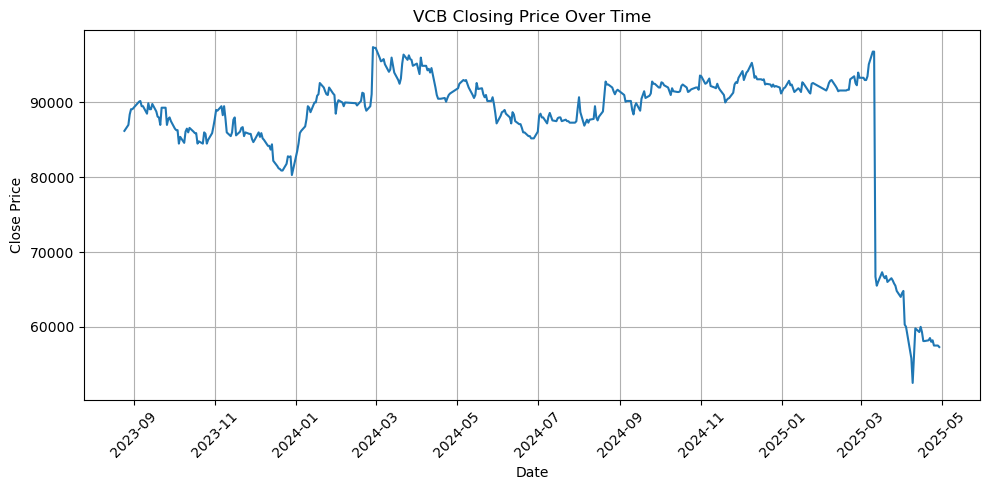

In [ ]:
# Sort by trading date
stock = stock.sort_values('TradingDate')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(stock['TradingDate'], stock['ClosePrice'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'{symb} Closing Price Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
stock

# Realtime data

In [ ]:
# Get realtime stock price and info
def get_rt_stock_price(symbol, token):
    url = "https://fc-data.ssi.com.vn/api/v2/Market/IntradayOhlc"
    headers = {
        "Authorization": f"Bearer {token}",
        "Accept": "application/json"
    }
    params = {
    "symbol": symbol,
    "FromDate": datetime.today().strftime("%d/%m/%Y"),
    "ToDate": datetime.today().strftime("%d/%m/%Y"),
    "PageSize": "50"
    }
    res = requests.get(url, headers=headers, params=params)
    res.raise_for_status()
    return res.json()

In [ ]:
rt_stock = get_rt_stock_price('GAS', token)

In [ ]:
rt_stock = pd.DataFrame(data['data'])
rt_stock

In [ ]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(rt_stock['Time'], rt_stock['Close'])
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'GAS Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
t = None
while True:
    rt = get_rt_stock_price('GAS', token)
    if t == None or rt['data'][0]['Time'] != t:
        print(rt['data'][0])
    t = rt['data'][0]['Time']
    time.sleep(2)

In [ ]:
fig = go.FigureWidget()
fig.add_scatter()
fig

In [ ]:
times = list()
prices = list()

for _ in range(75):
    rt = get_rt_stock_price('GAS', token)
    t = rt['data'][0]['Time']
    times.append(t)  
    price = rt['data'][0]['Close']
    prices.append(int(price))
    fig.data[0].x = times  
    fig.data[0].y = prices  
    time.sleep(2)

# VN Stock

In [9]:
from vnstock import Vnstock

symbol = 'BID'
stock = Vnstock().stock(symbol=symbol, source='VCI')
stk = stock.quote.history(start='2019-01-01', end=datetime.today().strftime("%Y-%m-%d"), to_df=True)
stk.tail()

,time,open,high,low,close,volume
1576,2025-04-28,35.30,35.30,34.40,34.55,3320200
1577,2025-04-29,34.60,34.75,34.35,34.55,2440200
1578,2025-05-05,34.65,34.85,34.30,34.85,1834700
1579,2025-05-06,34.90,35.20,34.55,34.95,2972100
1580,2025-05-07,34.80,34.90,34.60,34.90,2129800


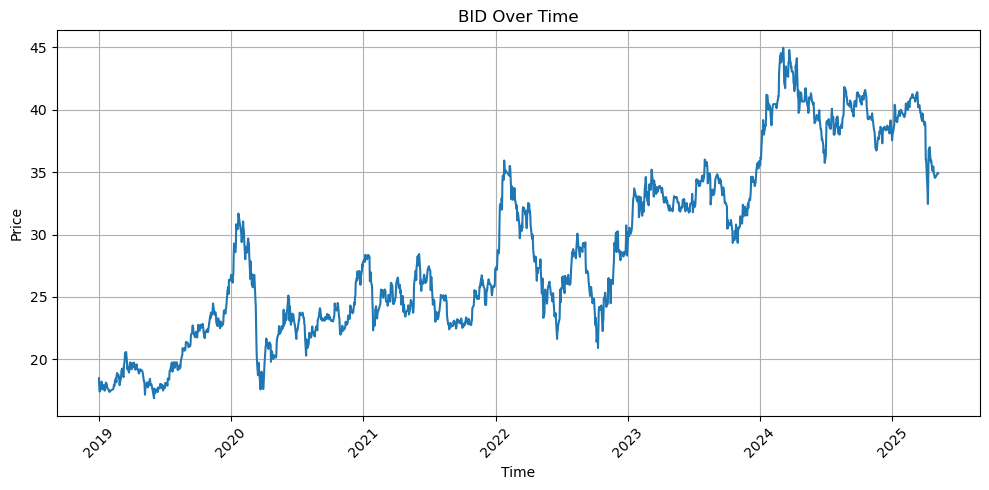

In [10]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(stk['time'], stk['close'])
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{symbol} Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Differencing

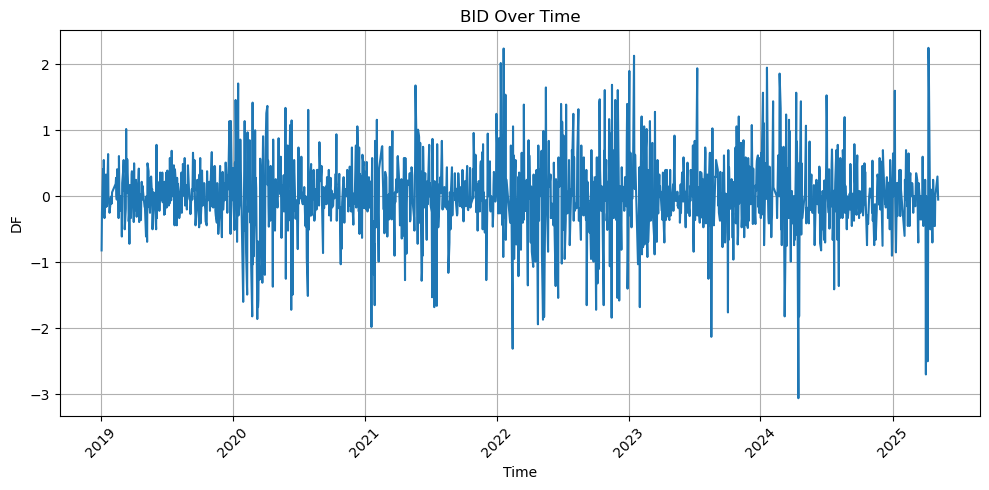

In [13]:
stk['df'] = stk['close'].diff()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(stk['time'], stk['df'])
plt.xlabel('Time')
plt.ylabel('DF')
plt.title(f'{symbol} Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
#Adfuller check stationary
adfuller(stk['df'].dropna())[1]

3.693215841965912e-30

## ARIMA

In [6]:
modelARIMA = ARIMA(stk['close'], order=(5, 1, 5))
model_fit = modelARIMA.fit()

# Forecast 
forecast = model_fit.forecast(steps=20)

Maximum Likelihood optimization failed to converge. Check mle_retvals


In [7]:
forecast

1581    56.997687
1582    56.942170
1583    56.945416
1584    57.015765
1585    57.062267
1586    57.040324
1587    57.008489
1588    57.035675
1589    57.094268
1590    57.116221
1591    57.092163
1592    57.083592
1593    57.120159
1594    57.164428
1595    57.169604
1596    57.153440
1597    57.160941
1598    57.199444
1599    57.228191
1600    57.227015
Name: predicted_mean, dtype: float64

# GARCH

In [8]:
# 3. Calculate returns from price
returns = stk['close'].pct_change().dropna()

# 4. Fit the GARCH(1,1) model
modelGARCH = arch_model(returns, vol='Garch', p=1, q=1)
garch_fit = modelGARCH.fit(disp='off')

# 5. Forecast the next 20 steps (out-of-sample)
forecast_horizon = 20
garch_forecast = garch_fit.forecast(horizon=forecast_horizon)

# 6. Get the forecasted mean and variance (volatility)
mean_forecast = garch_forecast.mean.iloc[-1].values
variance_forecast = garch_forecast.variance.iloc[-1].values
vol_forecast = np.sqrt(variance_forecast)

# 7. Simulate possible return paths (here, using mean=0 for simplicity)
simulated_returns = np.random.normal(loc=mean_forecast, scale=vol_forecast, size=forecast_horizon)

# 8. Convert forecasted returns to price path
last_price = stk['close'].iloc[-1]
forecasted_prices = [last_price]
for r in simulated_returns:
    forecasted_prices.append(forecasted_prices[-1] * (1 + r))
forecasted_prices = forecasted_prices[1:]  # Remove the initial last_price

forecasted_prices

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00026. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.



[58.2455080997559,
 57.45990258091132,
 57.339309125115776,
 56.75785887947893,
 56.98075464191799,
 56.14399081907987,
 55.78996087755054,
 56.27234079359672,
 56.788234889881025,
 56.80627188924233,
 56.3849520012673,
 56.25835443786238,
 57.48400730399188,
 56.274124176137434,
 56.917862611650335,
 57.3758241302048,
 58.03546661881932,
 58.527595123865524,
 59.274005111879646,
 59.22470315885837]

# Log return Analysis 

In [9]:
stk['log_return'] = np.log(stk['close'] / stk['close'].shift(1))

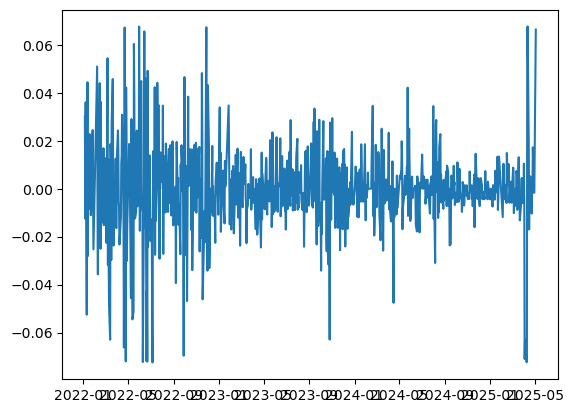

In [12]:
plt.plot(stk['time'], stk['log_return'])

In [3]:
stock.quote.intraday(symbol='VCB').tail(20)

RetryError: RetryError[<Future at 0x732cda96da90 state=finished raised ValueError>]

In [12]:
import requests

TOKEN = '8092343811:AAFMv0H66W0B1qzvwwoI5BNmCdMyC3rrHHk'
url = f"https://api.telegram.org/bot{TOKEN}/getUpdates"

response = requests.get(url)
print(response.json())

{'ok': True, 'result': [{'update_id': 681663065, 'message': {'message_id': 2, 'from': {'id': 817649025, 'is_bot': False, 'first_name': 'Thang', 'last_name': 'Winston', 'language_code': 'en'}, 'chat': {'id': 817649025, 'first_name': 'Thang', 'last_name': 'Winston', 'type': 'private'}, 'date': 1745911537, 'text': 'alo'}}]}


In [13]:
def send_telegram_message(message, token, chat_id):
    url = f"https://api.telegram.org/bot{token}/sendMessage"
    payload = {
        "chat_id": chat_id,
        "text": message
    }
    response = requests.post(url, data=payload)
    return response

In [ ]:
# Setup
BOT_TOKEN = TOKEN
CHAT_ID = '817649025'

# Send a test message
send_telegram_message("Hello from Jupyter Notebook!", BOT_TOKEN, CHAT_ID)

<Response [200]>

In [25]:
symbol = 'VCB'

while True: 
    stk = stock.quote.intraday(symbol=symbol, to_df=True)
    last_buy = stk[stk['match_type'] == 'Buy'].tail(1)
    last_buy_price = float(last_buy['price'].iloc[0])
    last_sell = stk[stk['match_type'] == 'Sell'].tail(1)
    last_sell_price = float(last_sell['price'].iloc[0])
    send_telegram_message(f"{symbol} Buy: {last_buy_price}   Sell: {last_sell_price}", BOT_TOKEN, CHAT_ID)
    time.sleep(5)

KeyboardInterrupt: 

In [22]:
stk = stock.quote.intraday(symbol='VCB', to_df=True)
last_buy = stk[stk['match_type'] == 'Buy'].tail(1)
float(last_buy['price'].iloc[0])

57700.0